 # The Role of Non-Profits in Public Health Service Provision
 
 ## By Charles Rahal and John Mohan
 
 #### Last Updated: 24/06/2021

The role and extent of external suppliers across statutory health insurance procurement processes varies widely and is a source of political contention throughout the modern world. We comprehensively examine the role of the Third Sector in public health procurement within publicly funded healthcare which runs parallel to private provision in a 'two-tier' system. We build a unique ‘Big Data’ based methodological pipeline which scrapes tens of thousands of heterogeneous accounting datasets from across the commissioning pipeline; from centralised commissioning (in the form of NHS England), decentralised Clinical Commissioning Groups, and various types of NHS Trusts. These datasets provide granular information on every element of procurement at the micro-level (where the value of a transaction is greater than twenty-five thousand pounds), mandated by transparency requirements introduced by David Cameron in 2012. We develop data scientific tools to parse these datasets and reconcile suppliers with institutional registers, with a focus on non-profits registered on the Charity Commission for England and Wales (CCEW). The processed dataset contains over four hundred and forty-five billion pounds worth of commissioning across over 1.9 million rows of clean data. Our substantive findings are multiple. We estimate that almost 1% at each level of the procurement heirarchy comes from institutions listed on the CCEW: a number relatively consistent across time, despite annual contractual patterns coinciding with the financial year. We show huge only a slight regional variation and analyze the 'North-South' divide. Linking to the International Classification of Non-profit Organizations (ICNPO) and undertaking natural language processing on charity objectives, we show a ranged involvement of multiple different types of charity classification, with more payments going to the ‘Social Services’ aggregate, but the highest cumulative values of payments going to the 'Health' aggregate. We analyse the distribution of contracts to charities across various sizes and ages, from grassroots to ‘Super Major’ non-profits. We conclude with a discussion of the sector more generally in relation to the effects of the controversial Health and Social Care Act of 2012.

### 1.1 Lets load some dependancies

Load in all of the libraries (`pip install requirements.txt` in '..') and custom functions specifically created for this project which are found in `analysis\general_analysis_functions.py` and `analysis\charity_analysis_functions.py`.

In [1]:
import os
import pandas as pd
from helper_functions import hide_toggle
from general_analysis_functions import (load_suppliers,
                                        load_payments,
                                        scoring_figures,
                                        plot_match_distribution,
                                        summarize_payments,
                                        plot_macro_overview,
                                        analyze_registers,
                                        calc_total_files,
                                        make_table_one,
                                        normalizer,
                                        overlapping_summary,
                                        check_payments,
                                        check_payments_abs)
from charity_analysis_functions import (tabulate_charities,
                                        icnpo_groupings,
                                        load_ccname,
                                        make_inc_table,
                                        load_ccfin,
                                        make_rolling_windows,
                                        load_ccclass,
                                        something_with_nuts1,
                                        plot_temporal_makemonths,
                                        load_icpno,
                                        cyclical_3200,
                                        build_charity_df,
                                        make_gdf,
                                        make_income_dists,
                                        make_ccg_to_gdf,
                                        plot_choropleths_ccg,
                                        plot_choropleths_trusts,
                                        plot_heatmaps,
                                        make_monthly,
                                        make_annual,
                                        charity_age,
                                        more_or_less_by_age,
                                        class_groupings,
                                        make_temporal_df,
                                        make_rolling_windows_top10,
                                        plot_temporal,
                                        plot_conc,
                                        make_obj_freq)
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:63% !important; }</style>"))
display(HTML("<style>.output_result { max-width:63% !important; }</style>"))
hide_toggle()

### 1.2 Set paths

Lets now set all of the paths we're going to need later on in the notebook.

In [2]:
data_path = os.path.abspath(os.path.join(os.getcwd(), '../..', 'data'))
cc_path = os.path.join(data_path, 'data_cc')
ch_path = os.path.join(data_path, 'data_ch')
nhsdigital_path = os.path.join(data_path, 'data_nhsdigital')
master_path = os.path.join(data_path, 'data_masteringest')
final_path = os.path.join(data_path, 'data_final')
recon_path = os.path.join(data_path, 'data_reconciled')
norm_path = os.path.join(data_path, 'data_support', 'norm_dict.tsv')
support_path = os.path.join(data_path, 'data_support')
shape_path = os.path.join(data_path, 'data_shapefiles')
figure_path = os.path.abspath(os.path.join(
                              os.path.join(os.getcwd(),
                                           '../..', 'papers', 'figures')))
table_path = os.path.abspath(os.path.join(
                             os.path.join(os.getcwd(),
                                          '../..', 'papers', 'tables')))
hide_toggle()

### 1.2 Load key datasets

Lets now load the hard earned datasets from all the data creation pipeline.

In [3]:
sup_df = load_suppliers(os.path.join(recon_path, 'recon_verified.tsv'))
ccg_pay_df = load_payments(os.path.join(final_path, 'payments_ccg_final.csv'))
trust_pay_df = load_payments(os.path.join(final_path, 'payments_trust_final.csv'))
nhsengland_pay_df = load_payments(os.path.join(final_path, 'payments_nhsengland_final.csv'))
cc_name = load_ccname(cc_path, norm_path)
cc_objects = pd.read_csv(os.path.join(cc_path, 'extract_objects.csv'),
                         error_bad_lines=False, warn_bad_lines=False,
                         encoding='utf-8', engine='c', lineterminator='\n')
icnpo_df, icnpo_lookup = load_icpno(support_path)
cc_fin = load_ccfin(cc_path)
cc_class = load_ccclass(cc_path)
hide_toggle()

The percent of charities without an address:  0.45474137344591414
The number of unique regnos in our database:  327547


### 1.3 Plot a general overview of some national accounting data

See the figure note in the paper for more details on exactly which data comes from where!

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


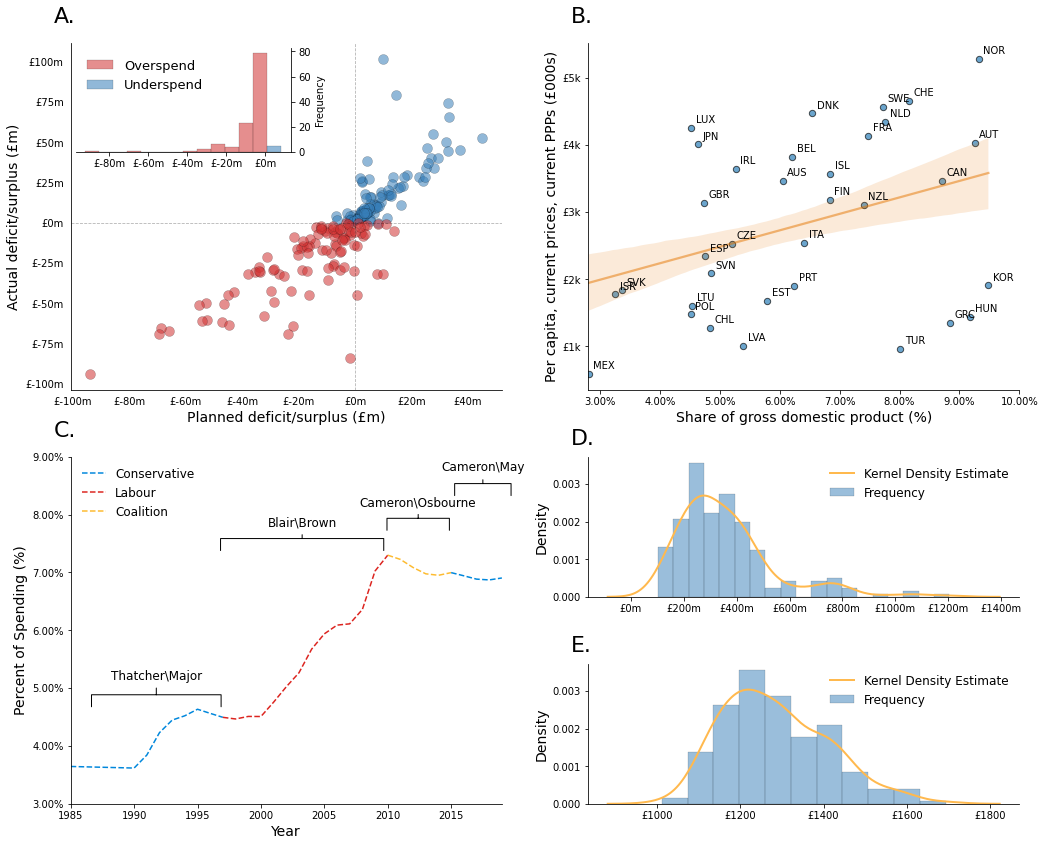

In [4]:
plot_macro_overview(data_path, figure_path)

## 2. Check and summarize the raw payments dataset

### 2.1 How many institutions were there at the time of the last scrape?

In [5]:
print('There are 221 Trusts in our meta list.')
print('There are 191 Trusts in our meta list.')
hide_toggle()

There are 221 Trusts in our meta list.
There are 191 Trusts in our meta list.


### 2.2 How many files did we get?

In [6]:
ccg_rawpath = os.path.join(data_path, 'data_nhsccgs', 'raw')
trust_rawpath = os.path.join(data_path, 'data_nhstrusts', 'raw')
ccg_files = calc_total_files(ccg_rawpath)[0]
ccg_folders = calc_total_files(ccg_rawpath)[1]
print('CCG folders: ' +  str(ccg_folders))
print('CCG files: ' +  str(ccg_files))
trust_files = calc_total_files(trust_rawpath)[0]
trust_folders = calc_total_files(trust_rawpath)[1]
print('Trust folders: ' +  str(trust_folders))
print('Trust files: ' +  str(trust_files))
hide_toggle()

CCG folders: 192
CCG files: 12727
Trust folders: 216
Trust files: 12758


### 2.3 Check the raw payments here

Write a function which verifies our manual check of the 50 largest payments of each dataset (i.e. for bad potentially serious bad parses)

In [7]:
check_payments(ccg_pay_df,
               os.path.join(data_path,'data_support',
                            'filechecker_ccg.csv'), data_path, 'ccg', 50)
check_payments(trust_pay_df,
               os.path.join(data_path,'data_support',
                            'filechecker_trust.csv'), data_path, 'trust', 50)
hide_toggle()

Cool! No more ccg payments to check by order...
Cool! No more ccg payments to check by groupby...
Cool! No more trust payments to check by order...
Cool! No more trust payments to check by groupby...


And then for absolute amounts:

In [8]:
check_payments_abs(ccg_pay_df,
                   os.path.join(data_path,'data_support',
                                          'abs_filechecker_ccg.csv'), data_path, 'ccg', 50)
check_payments_abs(trust_pay_df,
                   os.path.join(data_path,'data_support',
                                          'abs_filechecker_trust.csv'), data_path, 'trust', 50)
hide_toggle()

Cool! No more ccg absolute amount payments to check by order...
Cool! No more ccg absolute amount payments to check by groupby...
Cool! No more trust absolute amount payments to check by order...
Cool! No more trust absolute amount payments to check by groupby...


### 2.4 Analyze institutional registers

Lets quickly check just how unique the actual institutions going into our match are!

In [9]:
analyze_registers(ch_path, cc_path, nhsdigital_path, master_path)
hide_toggle()

Number unique raw CH entries: 4490685
Number non-duplicated normalized CH entries: 4489992
Number unique raw CC entries: 469691
Number non-duplicated normalized CC entries: 463733
Number unique raw NHS Digital entries: 45739
Number non-duplicated normalized NHS Digital entries: 45560
Number unique raw combined entries: 4851121
Number non-duplicated normalized combined entries: 4873882
There are 51575 normalised unique names on both CH and CC
There are 1408 normalised unique names on both CH and NHS
There are 1280 normalised unique names on both CC and NHS
There are 371 normalised unique names on all 3


### 2.5 Summarize the results of our data curation proceedure

Lets first summarize the payments from just CCGs:

In [10]:
summarize_payments(ccg_pay_df, 'CCG', 'supplier')
hide_toggle()

Describing cleaned CCG payments dataset!
Length of dataset: 646938
Total unique raw suppliers: 15830
Total unique verified suppliers: 15830
Total value (£) of dataset: 204110994238
Smallest value payment: -30100000
Biggest value payment: 58249359
Average value payment: 315503
Earliest payment was: 2010-12-24 00:00:00
Latest payment was: 2020-02-29 00:00:00
Most payments is:  NHS_LEE_CCG (20153)
Highest value payments is: NHS_LEE_CCG (£6097731281)
Most payments (other than "no match"): BMI HEALTHCARE LIMITED (6824)
Highest value of payments (other than "no match") is: SHEFFIELD TEACHING HOSPITALS NHS FOUNDATION TRUST (3257659088.0)
Number of organisations in clean dataset is: 173
Number of files in clean dataset is: 7747


and for NHS England:

In [11]:
summarize_payments(nhsengland_pay_df, 'NHS England', 'supplier')
hide_toggle()

Describing cleaned NHS England payments dataset!
Length of dataset: 601761
Total unique raw suppliers: 11979
Total unique verified suppliers: 11979
Total value (£) of dataset: 154820484769
Smallest value payment: -50000000
Biggest value payment: 340434000
Average value payment: 257279
Earliest payment was: 2013-04-24 00:00:00
Latest payment was: 2019-09-30 00:00:00
Most payments is:  NHS_England (601761)
Highest value payments is: NHS_England (£154820484769)
Most payments (other than "no match"): SPECSAVERS UK LIMITED (10857)
Highest value of payments (other than "no match") is: GUYS AND ST THOMAS NHS FOUNDATION TRUST (3387936729.0)
Number of organisations in clean dataset is: 1
Number of files in clean dataset is: 68


and then for just NHS Trusts...

In [12]:
summarize_payments(trust_pay_df, 'Trust', 'supplier')
hide_toggle()

Describing cleaned Trust payments dataset!
Length of dataset: 661226
Total unique raw suppliers: 24495
Total unique verified suppliers: 24495
Total value (£) of dataset: 86931704665
Smallest value payment: -108619414
Biggest value payment: 139956473
Average value payment: 131470
Earliest payment was: 2010-01-04 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_GUY_Trust (27022)
Highest value payments is: NHS_IMP_Trust (£3979230540)
Most payments (other than "no match"): NHS SUPPLY CHAIN (36196)
Highest value of payments (other than "no match") is: HM REVENUE AND CUSTOMS (9157152433.84)
Number of organisations in clean dataset is: 189
Number of files in clean dataset is: 8587


And then for a merged dataframe of both CCGs and NHS Trusts:

In [13]:
summarize_payments(pd.concat([nhsengland_pay_df, trust_pay_df, ccg_pay_df],
                             ignore_index=True), 'Combined', 'supplier')
hide_toggle()

Describing cleaned Combined payments dataset!
Length of dataset: 1909925
Total unique raw suppliers: 42998
Total unique verified suppliers: 42998
Total value (£) of dataset: 445863183672
Smallest value payment: -108619414
Biggest value payment: 340434000
Average value payment: 233445
Earliest payment was: 2010-01-04 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_England (601761)
Highest value payments is: NHS_England (£154820484769)
Most payments (other than "no match"): NHS SUPPLY CHAIN (36950)
Highest value of payments (other than "no match") is: HM REVENUE AND CUSTOMS (9570329945.84)
Number of organisations in clean dataset is: 363
Number of files in clean dataset is: 16311


### 2.6 Make Table One

And then wrangle this data into what goes into Table One in the accompanying paper:

In [14]:
make_table_one(ccg_pay_df, trust_pay_df, nhsengland_pay_df, table_path)
hide_toggle()

## 3 Visualise the approximate matches

Lets see how our matching algorithms perform by plotting Elastic Search match scores against Levenhstein ones.

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


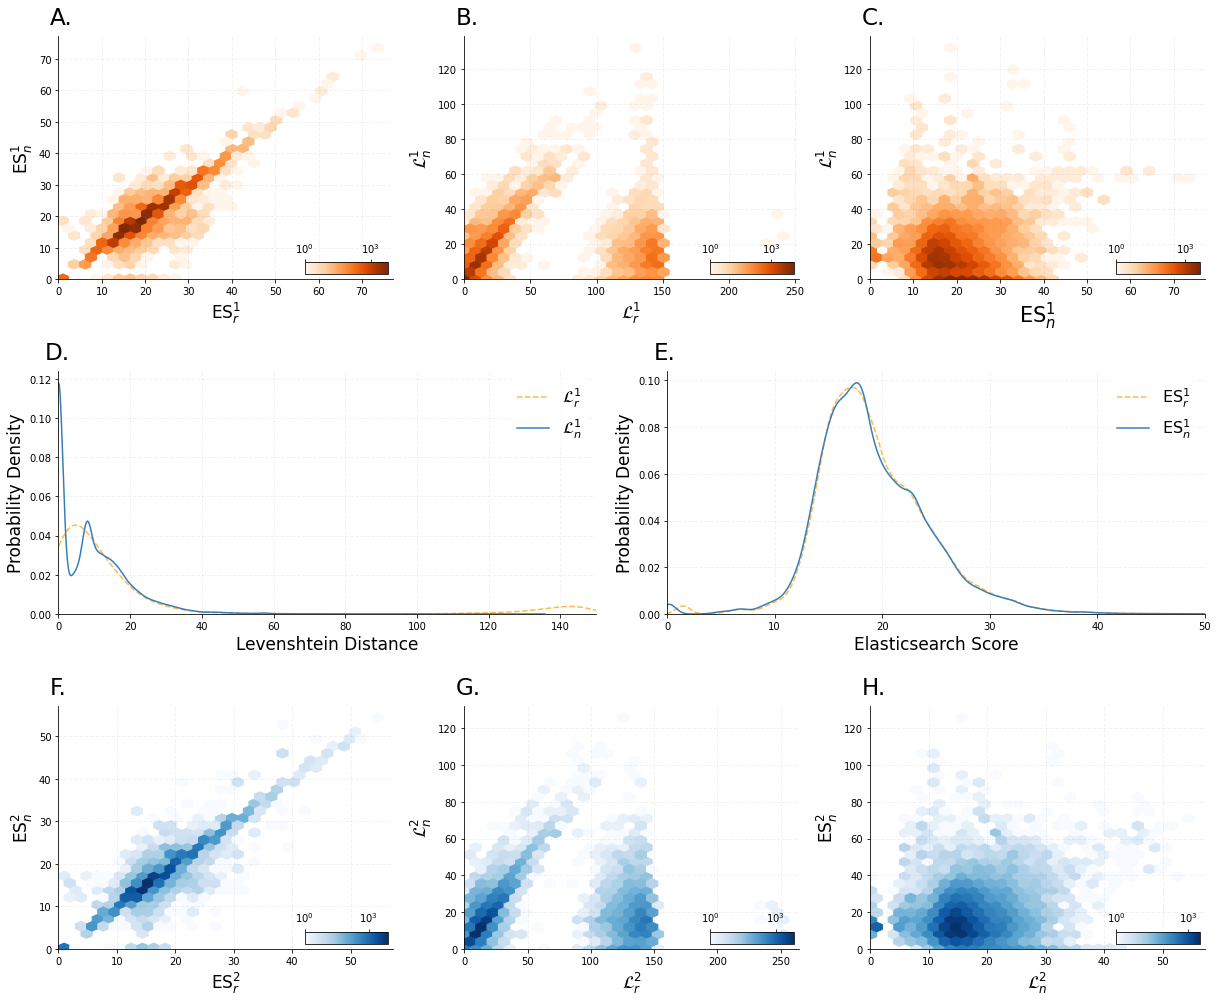

In [15]:
scoring_figures(sup_df, figure_path, (17, 14))
hide_toggle()

What are some of the most frequently unmatched entries?

In [16]:
concat = pd.concat([ccg_pay_df, trust_pay_df, nhsengland_pay_df])
concat = concat[concat['match_type']=='No Match']
count_df = concat.groupby(['query_string_n'])['amount'].count().sort_values(ascending=False)
count_df[0:5]

query_string_n
INLAND REVENUE CIS                      2291
NATIONAL OFFENDER MANAGEMENT SERVICE    1956
MINISTRY OF JUSTICE                     1677
IMPERIAL COLLEGE                        1592
DONCASTER GP                            1567
Name: amount, dtype: int64

What are some of the highest value unmatched entries?

In [17]:
concat = pd.concat([ccg_pay_df, trust_pay_df, nhsengland_pay_df])
concat = concat[concat['match_type']=='No Match']
count_df = concat.groupby(['query_string_n'])['amount'].sum().sort_values(ascending=False)
count_df[0:10]

query_string_n
INLAND REVENUE CIS                                          3.213644e+09
HULL AND EAST YORKSHIRE HOSPITALS NHS TRUST                 2.640191e+09
COLCHESTER HOSPITAL UNIVERSITY NHS FOUNDATION TRUST         1.304613e+09
TAMESIDE HOSPITAL NHS FOUNDATION TRUST                      9.003347e+08
WEST LONDON MENTAL HEALTH NHS TRUST                         8.567310e+08
PETERBOROUGH AND STAMFORD HOSPITALS NHS FOUNDATION TRUST    8.440407e+08
NHS HORSHAM AND MID SUSSEX CLINICAL COMMISSIONING GROUP     7.605057e+08
UNIVERSITY HOSPITAL OF NORTH STAFFORDSHIRE NHS TRUST        7.019224e+08
LIVERPOOL COMMUNITY HEALTH NHS TRUST                        5.507535e+08
NHS WEST HAMPSHIRE CLINICAL COMMISSIONING GROUP             4.607831e+08
Name: amount, dtype: float64

What are some of the biggest company only recipients by number of payments?

In [18]:
concat = pd.concat([ccg_pay_df, trust_pay_df, nhsengland_pay_df])
concat = concat[concat['match_type']=='Companies House']
count_df = concat.groupby(['CompanyName'])['amount'].count().sort_values(ascending=False)
count_df[0:5]

CompanyName
NHS PROFESSIONALS LIMITED              22857
NHS PROPERTY SERVICES LIMITED          17903
ROCHE PRODUCTS LIMITED                 13695
HEALTHCARE AT HOME LTD                 12836
NOVARTIS PHARMACEUTICALS UK LIMITED    11077
Name: amount, dtype: int64

What are some of the biggest company only recipients by value?

In [19]:
concat = pd.concat([ccg_pay_df, trust_pay_df, nhsengland_pay_df])
concat = concat[concat['match_type']=='Companies House']
count_df = concat.groupby(['CompanyName'])['amount'].sum().sort_values(ascending=False)
count_df[0:5]

CompanyName
NHS PROFESSIONALS LIMITED                      2.984508e+09
NHS PROPERTY SERVICES LIMITED                  1.341824e+09
THE COVENTRY AND RUGBY HOSPITAL COMPANY PLC    9.370274e+08
CARE UK CLINICAL SERVICES LIMITED              9.019509e+08
PARTNERSHIPS IN CARE LIMITED                   8.106066e+08
Name: amount, dtype: float64

## 4 Visualise the institutional distribution

Where does the money go? Lets plot an 'infographic' style thing with various measures

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


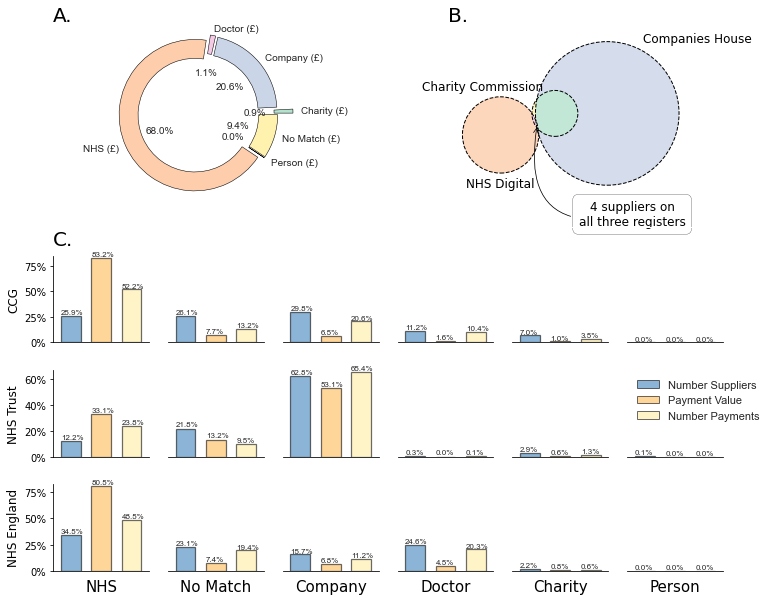

In [20]:
plot_match_distribution(sup_df, trust_pay_df, ccg_pay_df,
                        nhsengland_pay_df, figure_path, (12, 10))
hide_toggle()

The above figure shows only payments which are exclusively mapped to one register. What about including overlaps?

In [21]:
overlapping_summary(trust_pay_df, ccg_pay_df, nhsengland_pay_df)

Percent value INCLUDING overlapping payments to CH in NHS Trust data: 54.88
Percent value INCLUDING overlapping payments to CH in CCG data: 6.59
Percent value INCLUDING overlapping payments to CH in NHS England data: 6.85


Percent value INCLUDING overlapping payments to CC in NHS Trust data: 0.64
Percent value INCLUDING overlapping payments to CC in CCG data: 0.97
Percent value INCLUDING overlapping payments to CC in NHS England data: 0.86


In [22]:
concat = pd.concat([trust_pay_df, ccg_pay_df, nhsengland_pay_df], ignore_index=True)
concat = concat[concat['match_type'].str.contains('Companies House: Charity Commission: NHS Digital')]
concat = concat.drop_duplicates(subset=['CharityRegNo', 'CompanyNumber'])
concat.groupby(['supplier'])['amount'].sum().sort_values(ascending=False)


supplier
CHARITABLE FUNDS NORTHAMPTON GENERAL HOSPITAL                  77547.0
KINGS CHARITABLE TRUST                                         58750.0
WOKING HOSPICE TOTAL WRAY COMMON NURSING & RESIDENTIAL HOME    58285.0
IMPERIAL COLLEGE HEALTHCARE CHARITY                            43557.0
Name: amount, dtype: float64

## 5. Summarsize charitable payments and suppliers

Lets now get to the crux of the matter for the main non-profit analysis paper: where does the money actually go within the non-profit sector?

### 5.0 Build charity dataframe

Lets build some charity specific dataframes: these are for downstream analysis and only contain information on payments going to charities from trusts, ccgs, nhs england, and then the three combined.

In [23]:
pay_df_cc_ccg, cc_sup_ccg = build_charity_df(ccg_pay_df, icnpo_df, cc_fin, data_path)
hide_toggle()

We are missing 0 registration numbers
Can't do anything about that...
This seems to be where two charities have the same normalised name, and neither has been  removed from the register
This leaves us with 1041 charities with regnos.
We are missing 42 incomes
Can't do anything about that...
We are missing 0 ICNPO numbers which have charity numbers


In [24]:
pay_df_cc_nhsengland, cc_sup_nhsengland = build_charity_df(nhsengland_pay_df, icnpo_df, cc_fin, data_path)
hide_toggle()

We are missing 0 registration numbers
Can't do anything about that...
This seems to be where two charities have the same normalised name, and neither has been  removed from the register
This leaves us with 252 charities with regnos.
We are missing 12 incomes
Can't do anything about that...
We are missing 0 ICNPO numbers which have charity numbers


In [25]:
pay_df_cc_trust, cc_sup_trust = build_charity_df(trust_pay_df,
                                                 icnpo_df, cc_fin, data_path)
hide_toggle()

We are missing 0 registration numbers
Can't do anything about that...
This seems to be where two charities have the same normalised name, and neither has been  removed from the register
This leaves us with 520 charities with regnos.
We are missing 14 incomes
Can't do anything about that...
We are missing 0 ICNPO numbers which have charity numbers


In [26]:
pay_df_cc, cc_sup = build_charity_df(pd.concat([trust_pay_df, ccg_pay_df, nhsengland_pay_df],
                                         ignore_index=True),
                                         icnpo_df, cc_fin, data_path)
hide_toggle()

We are missing 0 registration numbers
Can't do anything about that...
This seems to be where two charities have the same normalised name, and neither has been  removed from the register
This leaves us with 1458 charities with regnos.
We are missing 65 incomes
Can't do anything about that...
We are missing 0 ICNPO numbers which have charity numbers


### 5.1 Charity summary

Lets now see what our _charitable_ datasets look like, filtering only on payments which have gone to charitable institutions (which do possibly overlap onto other institutions, but _not_ to other NHS Trusts or CCGs themselves). First for CCGs:

In [27]:
summarize_payments(pay_df_cc_ccg, 'charitable', 'CharityRegNo')
hide_toggle()

Describing cleaned charitable payments dataset!
Length of dataset: 23842
Total unique raw suppliers: 1188
Total unique verified suppliers: 1041
Total value (£) of dataset: 1979948736
Smallest value payment: -2705794
Biggest value payment: 3532145
Average value payment: 83044
Earliest payment was: 2012-09-07 00:00:00
Latest payment was: 2020-02-29 00:00:00
Most payments is:  NHS_LEE_CCG (1415)
Highest value payments is: NHS_LEE_CCG (£175549766)
Most payments (other than "no match"): NUFFIELD HEALTH (2273)
Highest value of payments (other than "no match") is: NUFFIELD HEALTH (272523676.0)
Number of organisations in clean dataset is: 169
Number of files in clean dataset is: 5998


and then NHS England:

In [28]:
summarize_payments(pay_df_cc_nhsengland, 'charitable', 'CharityRegNo')
hide_toggle()

Describing cleaned charitable payments dataset!
Length of dataset: 3789
Total unique raw suppliers: 266
Total unique verified suppliers: 252
Total value (£) of dataset: 1324326732
Smallest value payment: -1049190
Biggest value payment: 10000000
Average value payment: 349518
Earliest payment was: 2013-04-24 00:00:00
Latest payment was: 2019-09-30 00:00:00
Most payments is:  NHS_England (3789)
Highest value payments is: NHS_England (£1324326732)
Most payments (other than "no match"): THE FORWARD TRUST (378)
Highest value of payments (other than "no match") is: ST ANDREWS HEALTHCARE (718834054.0)
Number of organisations in clean dataset is: 1
Number of files in clean dataset is: 68


Then for Trusts:

In [29]:
summarize_payments(pay_df_cc_trust, 'CharityRegNo', 'CharityRegNo')
hide_toggle()

Describing cleaned CharityRegNo payments dataset!
Length of dataset: 9008
Total unique raw suppliers: 679
Total unique verified suppliers: 518
Total value (£) of dataset: 555567795
Smallest value payment: -849374
Biggest value payment: 2350782
Average value payment: 61674
Earliest payment was: 2010-01-29 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_NAS_Trust (357)
Highest value payments is: NHS_KIN_Trust (£33571263)
Most payments (other than "no match"): ANTHONY NOLAN (867)
Highest value of payments (other than "no match") is: ST JOHN AMBULANCE (39427012.0)
Number of organisations in clean dataset is: 171
Number of files in clean dataset is: 3258


And then for both combined:

In [30]:
summarize_payments(pay_df_cc, 'charitable', 'CharityRegNo')
hide_toggle()

Describing cleaned charitable payments dataset!
Length of dataset: 36639
Total unique raw suppliers: 1844
Total unique verified suppliers: 1456
Total value (£) of dataset: 3859843263
Smallest value payment: -2705794
Biggest value payment: 10000000
Average value payment: 105347
Earliest payment was: 2010-01-29 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_England (3789)
Highest value payments is: NHS_England (£1324326732)
Most payments (other than "no match"): NUFFIELD HEALTH (3021)
Highest value of payments (other than "no match") is: ST ANDREWS HEALTHCARE (730926246.0)
Number of organisations in clean dataset is: 341
Number of files in clean dataset is: 9296


### 5.2 Tabulate the charities (groupby)

Stack these first two tables together vertically in the paper. They show which non-profits are getting most money. The nameno which maps to the National Blood Authority is curious. First for CCGs:

In [31]:
tabulate_charities(pay_df_cc_ccg,
                   icnpo_df, cc_fin,
                   table_path, 'ccg_payments_to_charities_count.csv',
                   'count')
hide_toggle()

 CharityRegNo    amount  count  ICNPO       income  CC Rank
       205533 272523676   2273   3100 4835600000.0        3
       265543  41711869   1086   3400 1603164000.0       16
       289145  38626896    795   3400  207800000.0      271
       207994  53364388    554   3400 1091030000.0       33
       296645  21500537    502   3400  666008000.0       69
      1104951  11492938    446   3300 1369600000.0       26
      1053814  36800666    438   3200   76315321.0      961
      1046624  47817518    421   3400  192440197.0      304
      1052076  41388413    365   3200  677509000.0       68
      1083995  13655293    359   6200 1429769000.0       23


In [32]:
tabulate_charities(pay_df_cc_ccg,
                   icnpo_df, cc_fin,
                   table_path, 'ccg_payments_to_charities_amount.csv',
                   'amount')

 CharityRegNo    amount  count  ICNPO       income  CC Rank
       205533 272523676   2273   3100 4835600000.0        3
       292880  61326856    348   4100  176846091.0      350
       207994  53364388    554   3400 1091030000.0       33
      1046624  47817518    421   3400  192440197.0      304
       265543  41711869   1086   3400 1603164000.0       16
      1052076  41388413    365   3200  677509000.0       68
       289145  38626896    795   3400  207800000.0      271
      1053814  36800666    438   3200   76315321.0      961
       289466  34461277    107   3200   47215631.0     1546
      1008587  26586982    351   4100  407220055.0      122


and then for NHS England:

In [33]:
tabulate_charities(pay_df_cc_nhsengland,
                   icnpo_df, cc_fin,
                   table_path, 'nhsengland_payments_to_charities_count.csv',
                   'count')
hide_toggle()

 CharityRegNo    amount  count  ICNPO       income  CC Rank
      1001701  44810044    378   7200  137168240.0      480
      1104951 718834054    358   3300 1369600000.0       26
      1127049 109023655    168   3400  149968584.0      427
       284880  15269975    144   6200  164287246.0      381
       205533  15915996    139   3100 4835600000.0        3
       205907  56540223    116   3100  219110000.0      256
      1090790   9962911    110   6100   63517341.0     1159
       288018  30341355    100   4100  173429000.0      358
       211091  10927501     96   3300  129900753.0      520
      1090329  12521553     95   3100  136536557.0      483


In [34]:
tabulate_charities(pay_df_cc_nhsengland,
                   icnpo_df, cc_fin,
                   table_path, 'nhsengland_payments_to_charities_amount.csv',
                   'amount')
hide_toggle()

 CharityRegNo    amount  count  ICNPO       income  CC Rank
      1104951 718834054    358   3300 1369600000.0       26
      1127049 109023655    168   3400  149968584.0      427
      1014851  78283672     17   3200  105345000.0      652
       205907  56540223    116   3100  219110000.0      256
      1001701  44810044    378   7200  137168240.0      480
       288018  30341355    100   4100  173429000.0      358
       206002  17176623     70   3300  108814000.0      621
      1089313  17036477     60   7100   18067929.0     3426
       205533  15915996    139   3100 4835600000.0        3
       284880  15269975    144   6200  164287246.0      381


Then for trusts:

In [35]:
tabulate_charities(pay_df_cc_trust, 
                   icnpo_df, cc_fin,
                   table_path, 'trust_payments_to_charities_count.csv',
                   'count')
hide_toggle()#amount and count

 CharityRegNo   amount  count  ICNPO       income  CC Rank
       803716 29667001    867   3400  293534000.0      185
      1077265 39427012    837   3400  600100000.0       82
       205533 38057411    609   3100 4835600000.0        3
       284880 26465000    399   6200  164287246.0      381
      1090790 10309171    255   6100   63517341.0     1159
       514829  8329605    158   3300   80733083.0      895
       264713 15586855    151   4100  159965000.0      388
      1037116 21374591    146   2410   55061439.0     1345
       220949  9047624    134   4100 1544800000.0       17
       297370 12074948    119   3400   41209886.0     1745


In [36]:
tabulate_charities(pay_df_cc_trust, 
                   icnpo_df, cc_fin,
                   table_path, 'trust_payments_to_charities_amount.csv',
                   'amount')
hide_toggle()

 CharityRegNo   amount  count  ICNPO       income  CC Rank
      1077265 39427012    837   3400  600100000.0       82
       205533 38057411    609   3100 4835600000.0        3
       803716 29667001    867   3400  293534000.0      185
       284880 26465000    399   6200  164287246.0      381
      1037116 21374591    146   2410   55061439.0     1345
       216250 15669569     58   4100 2060677000.0       14
       264713 15586855    151   4100  159965000.0      388
      1081182 12558058     29   4100  103812731.0      665
       297370 12074948    119   3400   41209886.0     1745
      1090790 10309171    255   6100   63517341.0     1159


And then for all three:

In [37]:
tabulate_charities(pay_df_cc,
                   icnpo_df, cc_fin,
                   table_path, 'both_payments_to_charities_count.csv',
                   'count')
hide_toggle()

 CharityRegNo    amount  count  ICNPO       income  CC Rank
       205533 326497083   3021   3100 4835600000.0        3
       265543  43334457   1117   3400 1603164000.0       16
       803716  29667001    867   3400  293534000.0      185
       289145  41674886    862   3400  207800000.0      271
      1077265  39927011    844   3400  600100000.0       82
      1104951 730926246    834   3300 1369600000.0       26
       207994  55679994    600   3400 1091030000.0       33
       296645  25939290    577   3400  666008000.0       69
       284880  41734975    543   6200  164287246.0      381
      1001701  51499364    461   7200  137168240.0      480


In [38]:
tabulate_charities(pay_df_cc,
                   icnpo_df, cc_fin,
                   table_path, 'both_payments_to_charities_amount.csv',
                   'amount')
hide_toggle()

 CharityRegNo    amount  count  ICNPO       income  CC Rank
      1104951 730926246    834   3300 1369600000.0       26
       205533 326497083   3021   3100 4835600000.0        3
      1127049 110947036    224   3400  149968584.0      427
      1014851  78283672     17   3200  105345000.0      652
       292880  61326856    348   4100  176846091.0      350
       205907  58243969    140   3100  219110000.0      256
       207994  55679994    600   3400 1091030000.0       33
      1001701  51499364    461   7200  137168240.0      480
      1046624  50120084    448   3400  192440197.0      304
       265543  43334457   1117   3400 1603164000.0       16


### 5.3 ICNPO and Class Distributions

#### 5.3.1. Lets first look at how this grouping looks over all ICNPO groups

In [39]:
icnpo_groupings(pay_df_cc, pay_df_cc_ccg, pay_df_cc_trust, pay_df_cc_nhsengland, 
                icnpo_df, icnpo_lookup, table_path)
hide_toggle()

                             icnpo_group  count_ccg  amount_ccg  count_trust  amount_trust  count_eng  amount_eng
icnpo                                                                                                            
1100                   Culture and sport       1.25        0.05         1.54          0.21       1.59        0.01
1200                   Culture and sport       0.96        0.08         0.58          0.23       0.79        0.11
2100                           Education       0.58        0.02         1.16          0.67       1.19        0.01
2120                           Education       0.10        0.02         0.19          0.02       0.00        0.00
2200                           Education       0.29        0.11         0.77          0.22       0.40        0.00
2300                           Education       0.96        0.05         2.12          1.00       1.19        0.03
2400                           Education       0.77        0.04         2.12          0.

#### 5.3.2 Lets do some basic NLP on the self described non-profit purposes

[nltk_data] Downloading package stopwords to /home/porco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/porco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


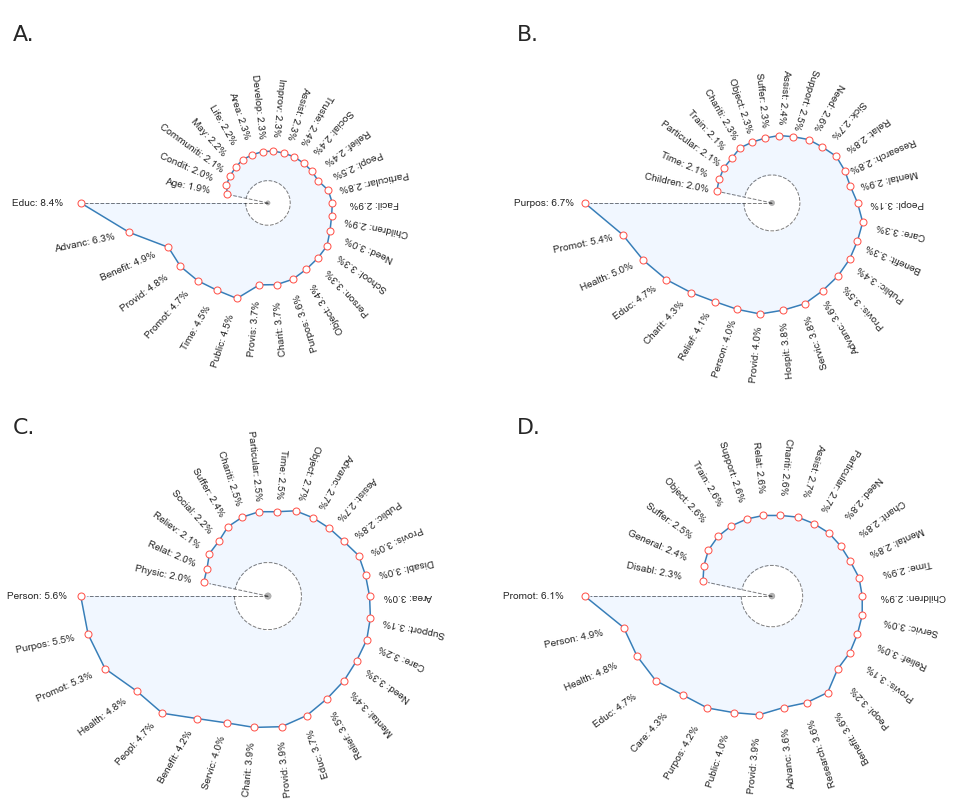

In [40]:
make_obj_freq(cc_objects, pay_df_cc_ccg, pay_df_cc_trust,
              pay_df_cc_nhsengland, figure_path)

#### 5.3.3. Then lets look at how this grouping looks over all CC Classes (non-unique)

In [41]:
class_groupings(pay_df_cc, pay_df_cc_ccg, pay_df_cc_trust,
                pay_df_cc_nhsengland, cc_class,
                table_path)
hide_toggle()

                                            classtext  amo_ccg  cou_ccg  amo_tr  cou_tr  amo_eng  cou_eng
0                               Accommodation/housing     1.75     2.26    2.15    2.12     0.80     1.74
1                Acts As An Umbrella Or Resource Body     0.98     2.13    1.52    2.12     1.93     2.90
2                                       Amateur Sport     0.19     0.68    0.19    0.60     0.01     0.22
3                                             Animals     0.00     0.03    0.04    0.02      NaN      NaN
4           Armed Forces/emergency Service Efficiency     0.01     0.05    0.01    0.06     0.01     0.13
5                       Arts/culture/heritage/science     0.21     0.80    0.38    0.93     0.03     0.63
6                               Children/young People     6.05     5.51    6.40    5.40     9.54     6.34
7                                          Disability     4.49     5.47    3.29    3.97     1.85     4.38
8           Economic/community Development/emp

### 5.4 Geospatial Distribution

CCGs map into distinct CCG coverage polygons, so lets use the NHS shapefile data to see how different trusts (>50 payments) vary their spending to CC organisations, printing out the highest number of %s to VCS charities:

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


We have 191 trusts in our dataset
Of them, 165 procure < 2.5% from CCEW by value
Of them, 66 procure < 2.5% from CCEW by count

The top 5 Trusts by %to VCS are: 

             dept    amount_cc  amount_pc_cc  count_cc
25   nhs_camd_ccg    1928974.0      3.977839      23.0
94    nhs_nel_ccg   54032233.0      3.938829     342.0
185   nhs_lee_ccg  175549766.0      2.878936    1415.0
173   nhs_nag_ccg    2735907.0      2.445316      21.0
143  nhs_stok_ccg   28791296.0      2.442488     245.0


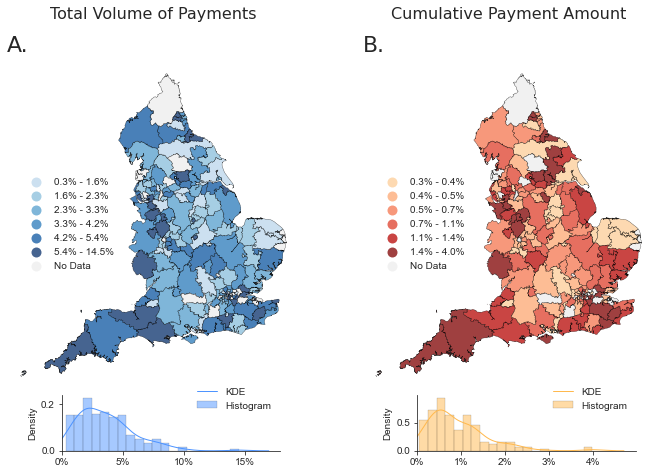

In [42]:
ccg_merged = make_ccg_to_gdf(ccg_pay_df,
                             pay_df_cc_ccg, support_path)
gdf=make_gdf(ccg_merged, shape_path, support_path)
plot_choropleths_ccg(gdf, figure_path)
hide_toggle()

Trusts dont map exactly to boundaries, so we geocode their exact address and plot the same metrics:

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


We have 170 trusts in our dataset
Of them, 143 procure < 2.5% from CCEW by value
Of them, 118 procure < 2.5% from CCEW by count

The top 5 Trusts by %to VCS are: 

              dept  charity_amount  pc_amount  charity_count
39   NHS_DHC_Trust      25997483.0  20.280460          311.0
102  NHS_NAS_Trust      29480384.0  11.561094          357.0
10   NHS_BER_Trust       1174710.0   9.549714            6.0
106  NHS_NEA_Trust       9910527.0   9.245401          168.0
112  NHS_NOT_Trust      23830635.0   7.772180          335.0


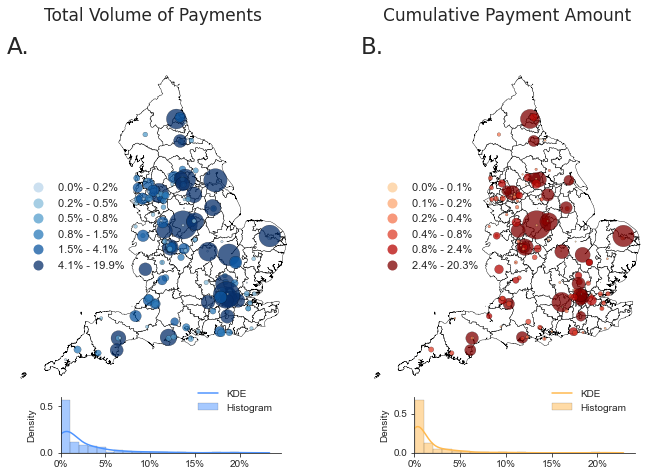

In [43]:
plot_choropleths_trusts(support_path, shape_path, figure_path,
                        trust_pay_df, pay_df_cc)
hide_toggle()

Just what is it that DHC is spending so much on from the CCEW?

In [44]:
dhc_cc = trust_pay_df[(trust_pay_df['match_type'].str.contains('Charity')) &
                      (trust_pay_df['dept'].str.contains('_DHC_'))]
dhc = trust_pay_df[trust_pay_df['dept'].str.contains('_DHC_')]
print('There are ' + str(len(dhc_cc)) + ' payments to CCEW organisations from DHC')
print('CCEW organisations supplying DHC: \n\n' + str(dhc_cc.groupby('verif_match')['amount'].sum().\
      sort_values(ascending=False)))
print('\nTop supplier gets: ' + str(dhc_cc.groupby('verif_match')['amount'].sum().\
                                    sort_values(ascending=False)[0]/dhc['amount'].sum()))

There are 311 payments to CCEW organisations from DHC
CCEW organisations supplying DHC: 

verif_match
PHOENIX HOUSE                           14879960.0
DERWENT RURAL COUNSELLING SERVICE        7331454.0
AQUARIUS ACTION PROJECTS                 2055421.0
DERBYSHIRE ALCOHOL ADVICE SERVICE        1444559.0
SPODA                                      80160.0
THE RICHMOND FELLOWSHIP                    80009.0
HEALTHWATCH DERBYSHIRE LIMITED             40000.0
TURNING POINT                              33786.0
ST ANDREWS HEALTHCARE                      27047.0
RELATE DERBY AND SOUTHERN DERBYSHIRE       25087.0
Name: amount, dtype: float64

Top supplier gets: 0.11607755898971313


Lets also look at something more specific with regards to geographic variation:

In [45]:
something_with_nuts1(support_path, trust_pay_df, shape_path)

                                amount   count  count_ccew   amount_ccew  count_ccew_pc  amount_ccew_pc
nuts118nm                                                                                              
East Midlands (England)   7.186258e+09   58219        1043  6.862488e+07       1.791511        0.954946
East of England           7.129508e+09   59977        1032  6.972245e+07       1.720660        0.977942
London                    2.336624e+10  172275        2055  1.291513e+08       1.192860        0.552726
North East (England)      3.801700e+09   29679         418  2.518260e+07       1.408403        0.662404
North West (England)      1.518952e+10   97213        1124  5.686107e+07       1.156224        0.374344
South East (England)      7.784538e+09   62368         599  3.165798e+07       0.960428        0.406678
South West (England)      7.036263e+09   66053        1207  6.715900e+07       1.827320        0.954470
West Midlands (England)   8.098928e+09   65573         838  6.91

### 5.5 Charity Age Distribution

How do charities which recieve payments from the NHS differ in terms of their age in terms to those who don't?

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


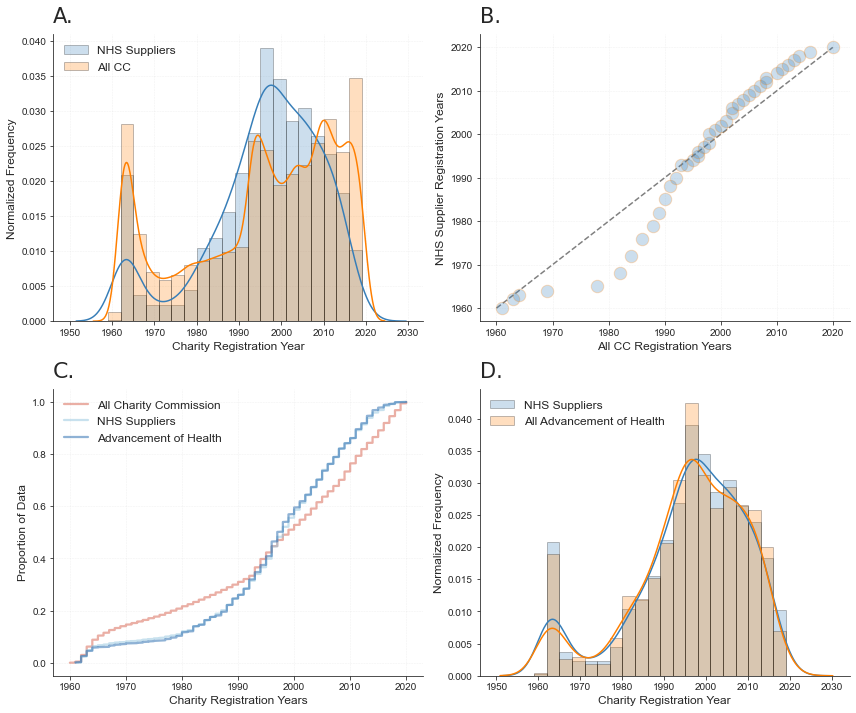

In [46]:
cc_name = cc_name.sort_values(by='regdate', ascending=True)
cc_name_onedate = cc_name.drop_duplicates(subset=['regno'], keep='first')
charity_age(pd.concat([trust_pay_df, ccg_pay_df, nhsengland_pay_df],
                      ignore_index=True),
            cc_sup, cc_name_onedate, cc_class, figure_path)

In [47]:
now = pd.to_datetime('now')
cc_sup_onedate = pd.merge(cc_sup, cc_name_onedate, how='left', left_on='CharityRegNo', right_on='regno')
cc_sup_onedate['age'] = (now - cc_sup_onedate['regdate']).dt.total_seconds() / (60*60*24*365.25)
cc_name['age'] = (now - cc_name['regdate']).dt.total_seconds() / (60*60*24*365.25)
print('Average age of NHS suppliers: ' + str(cc_sup_onedate['age'].mean()))
print('Average age of all CCEW: ' + str(cc_name['age'].mean()))

Average age of NHS suppliers: 24.827845992525713
Average age of all CCEW: 27.41432498451707


Do older, more established charities get _more_ income from NHS orgs?

In [48]:
more_or_less_by_age(cc_sup_onedate)

Full sample:

Correlation between age and amount:  0.0574552127396558
Correlation between age and count: 0.14411689355835475
Correlation between age and amount by rank:  0.24831356337982466
Correlation between age and count by rank: 0.23301790842693662
-------------------------------------------
Companies registered before 2012:

Correlation between age and amount:  0.0470035248359428
Correlation between age and count: 0.13189329113285797
Correlation betwen age and amount, by rank:  0.2120319598619513
Correlation between age and count, by rank:  0.18522446178829008


The percent of charities without an address:  0.45474137344591414
The number of unique regnos in our database:  327547
We have 205919 regnos in the ccew...
We have 167809 regnos with income data!
We have 258 regnos of NHS England data in total.
We have 3384 rows of NHS England data with post-2012 income data
We have 221 rows of NHS England data with pre-2012 income data
We have 1049 regnos of CCG data in total.
We have 13864 rows of CCG data with post-2012 income data
We have 904 rows of CCG data with pre-2012 income data
We have 536  regnos of trust data in total.
We have 6967 rows of trust data with post-2012 income data
We have 457 rows of trust data with pre-2012 income data


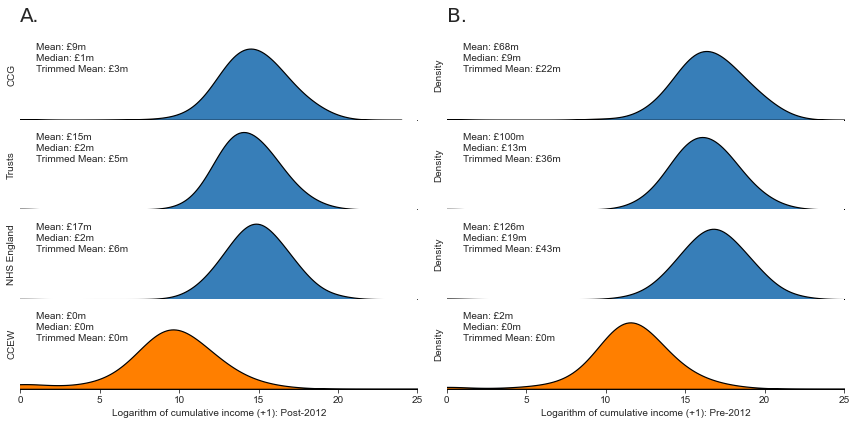

In [49]:
make_income_dists(nhsengland_pay_df, trust_pay_df, ccg_pay_df, cc_path, norm_path, figure_path)

Lets also look at payments decomposed into the NCVO definition of charity income boundaries:

In [50]:
make_inc_table(cc_path, norm_path, nhsengland_pay_df,
               trust_pay_df, ccg_pay_df, '2018',
               os.path.join(table_path, 'income_table_2018.csv'))

The percent of charities without an address:  0.45474137344591414
The number of unique regnos in our database:  327547
                      Minor    Small   Medium    Large    Major SuperMajor
Entire CCEW          37.465  37.5578  19.8449   4.3213   0.7519     0.0591
Organisation Count   1.1839   2.4467  33.4649  44.5935  16.4167     1.8942
Percent of Payments    0.54     4.66    10.45    26.54    35.93      21.87
Percent of Amount      0.21     8.57     12.1    22.73    27.14      29.26


In [51]:
make_inc_table(cc_path, norm_path, nhsengland_pay_df,
               trust_pay_df, ccg_pay_df, '2011',
               os.path.join(table_path, 'income_table_2011.csv'))

The percent of charities without an address:  0.45474137344591414
The number of unique regnos in our database:  327547
                       Minor    Small   Medium    Large    Major SuperMajor
Entire CCEW          42.3882  36.7024  16.3094   3.8602   0.6934     0.0464
Organisation Count    0.6436   3.7812  37.6508  41.5929  14.4811     1.8504
Percent of Payments     0.71     0.51    16.78    29.85    34.33      17.82
Percent of Amount       0.54      0.2     21.7    26.67    24.05      26.84


### 5.6 Over TIme

How has this changed over time? First break it down by ICNPO, then aggregate up

In [52]:
ts_trust_month, ts_icnpo_plot_trust = make_temporal_df(trust_pay_df,
                                                       pay_df_cc_trust,
                                                       icnpo_df
                                                       #, cc_name
                                                      )
ts_ccg_month, ts_icnpo_plot_ccg = make_temporal_df(ccg_pay_df,
                                                   pay_df_cc_ccg,
                                                   icnpo_df
                                                   #cc_name
                                                  )
ts_nhsengland_month, ts_icnpo_plot_nhsengland = make_temporal_df(nhsengland_pay_df,
                                                                 pay_df_cc_nhsengland,
                                                                 icnpo_df
                                                                 #cc_name
                                                                )

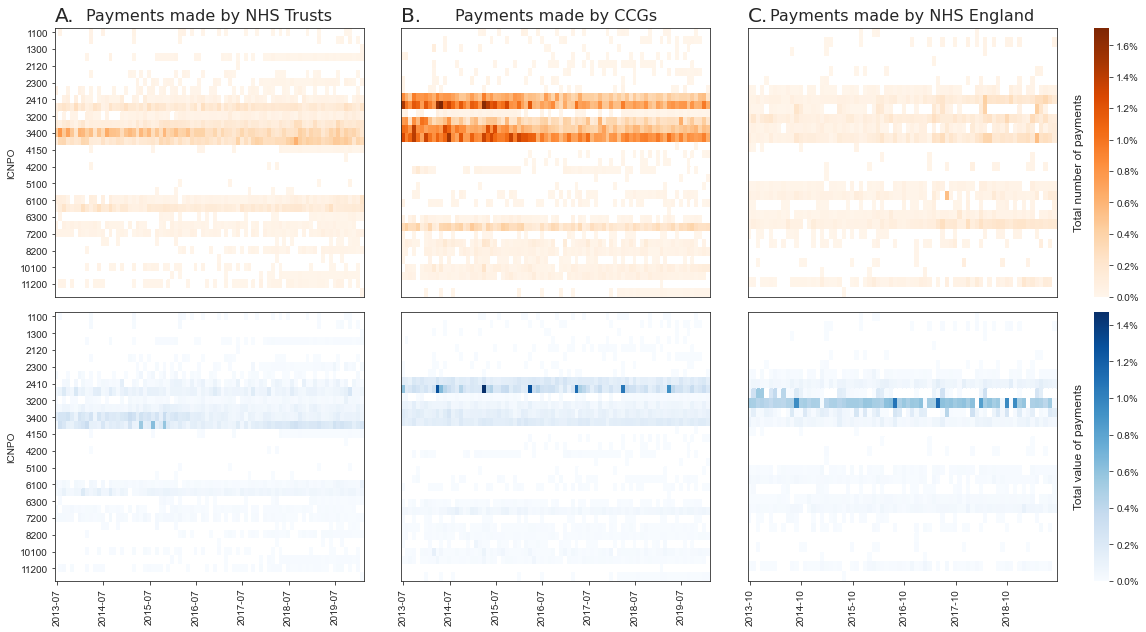

In [53]:
plot_heatmaps(ts_icnpo_plot_trust, ts_icnpo_plot_ccg, ts_icnpo_plot_nhsengland, figure_path)

Lets have a quick look at that cyclical pattern in the middle lower panel above!

The average percent of payments going to ICNPO 3200 in April:  1.193
The average percent of payments going to ICNPO 3200 in all other months:  0.274


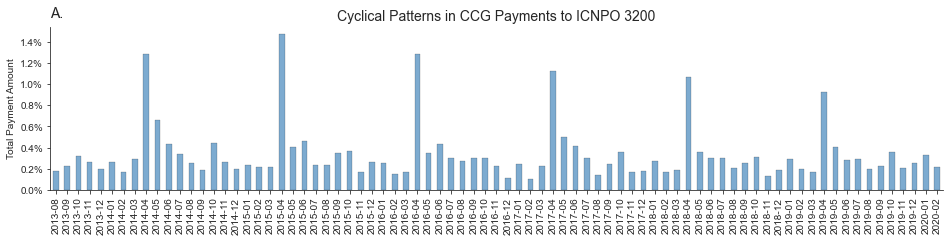

In [54]:
cyclical_3200(ts_icnpo_plot_ccg)

Lets now make the monthly and annual data:

In [55]:
ts_ccg_annual = make_annual(ccg_pay_df, pay_df_cc_ccg)
ts_trust_annual = make_annual(trust_pay_df, pay_df_cc_trust)
ts_ccg_monthly = make_monthly(ccg_pay_df, pay_df_cc_ccg)
ts_trust_monthly = make_monthly(trust_pay_df, pay_df_cc_trust)
ts_nhsengland_monthly = make_monthly(nhsengland_pay_df, pay_df_cc_nhsengland)
ts_nhsengland_annual = make_annual(nhsengland_pay_df, pay_df_cc_nhsengland)

Make a table from the monthly figures to check out cyclicality in general:

In [56]:
plot_temporal_makemonths(ts_ccg_monthly, ts_trust_monthly, ts_nhsengland_monthly)

       Count_CCG  Amount_CCG  Count_Trust  Amount_Trust  Count_NHSEngland  Amount_NHSEngland
Month                                                                                       
01      4.058276    0.958740     1.337504      0.624606          0.559633           0.940519
02      3.546562    0.797384     1.348302      0.674788          0.550905           0.800880
03      3.045982    0.830098     1.330851      0.680444          0.683578           0.619587
04      4.038000    1.756798     1.229455      0.578807          0.619079           0.857978
05      4.111486    1.089658     1.256498      0.612836          0.687514           0.860604
06      3.566760    0.975808     1.393656      0.605722          0.516115           0.938905
07      4.284179    1.005798     1.345180      0.603522          0.710429           0.826666
08      3.463076    0.793815     1.459643      0.717840          0.740188           1.066649
09      3.379855    0.805983     1.492180      0.676780          0.745

Make some rolling datasets of various windows to plot in the main time series figure for the paper:

In [57]:
rolling_df_45 = make_rolling_windows(ccg_pay_df, trust_pay_df, nhsengland_pay_df, 90)
rolling_df_365 = make_rolling_windows(ccg_pay_df, trust_pay_df, nhsengland_pay_df, 365)

And finally, plot the main time series type of figure for the paper:

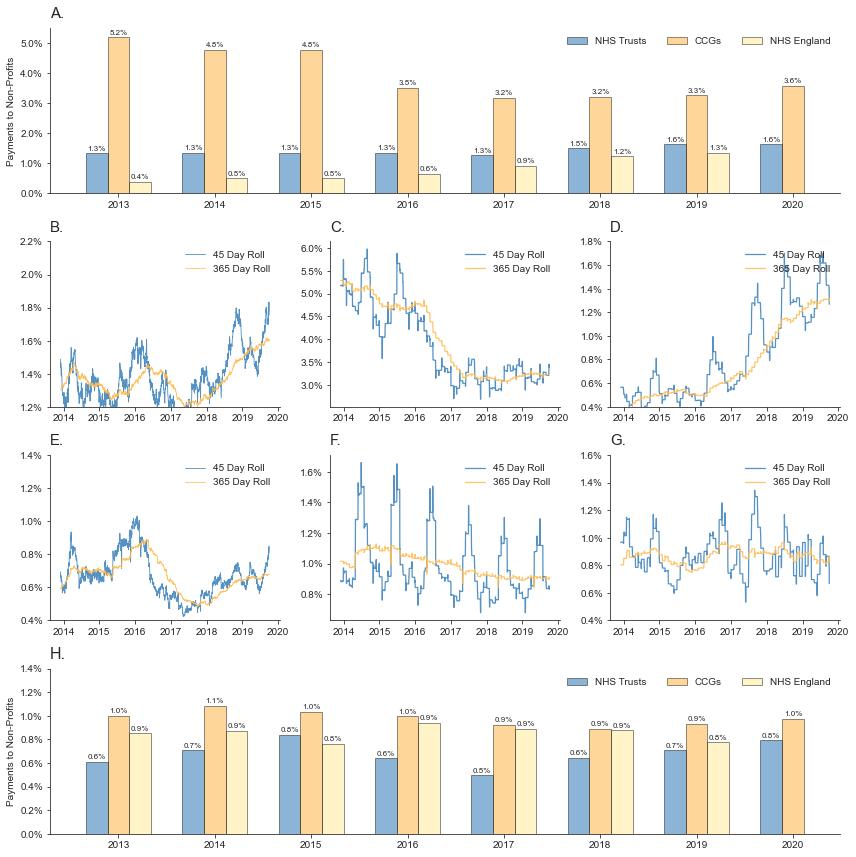

In [58]:
plot_temporal(ts_ccg_annual, ts_trust_annual, ts_nhsengland_annual,
              rolling_df_45, rolling_df_365, figure_path)

In [59]:
rolling_df_45_top10 = make_rolling_windows_top10(ccg_pay_df,
                                                 trust_pay_df,
                                                 nhsengland_pay_df,
                                                 pd.concat([nhsengland_pay_df, trust_pay_df, ccg_pay_df],
                                                 ignore_index=True),
                                                 45)

In [63]:
rolling_df_90_top10 = make_rolling_windows_top10(ccg_pay_df,
                                                 trust_pay_df,
                                                 nhsengland_pay_df,
                                                 pd.concat([nhsengland_pay_df, trust_pay_df, ccg_pay_df],
                                                 ignore_index=True),
                                                 90)

In [64]:
rolling_df_180_top10 = make_rolling_windows_top10(ccg_pay_df,
                                                  trust_pay_df,
                                                  nhsengland_pay_df,
                                                  pd.concat([nhsengland_pay_df, trust_pay_df, ccg_pay_df],
                                                  ignore_index=True),
                                                  180)

In [65]:
rolling_df_365_top10 = make_rolling_windows_top10(ccg_pay_df,
                                                  trust_pay_df,
                                                  nhsengland_pay_df,
                                                  pd.concat([nhsengland_pay_df, trust_pay_df, ccg_pay_df],
                                                  ignore_index=True),
                                                  365)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


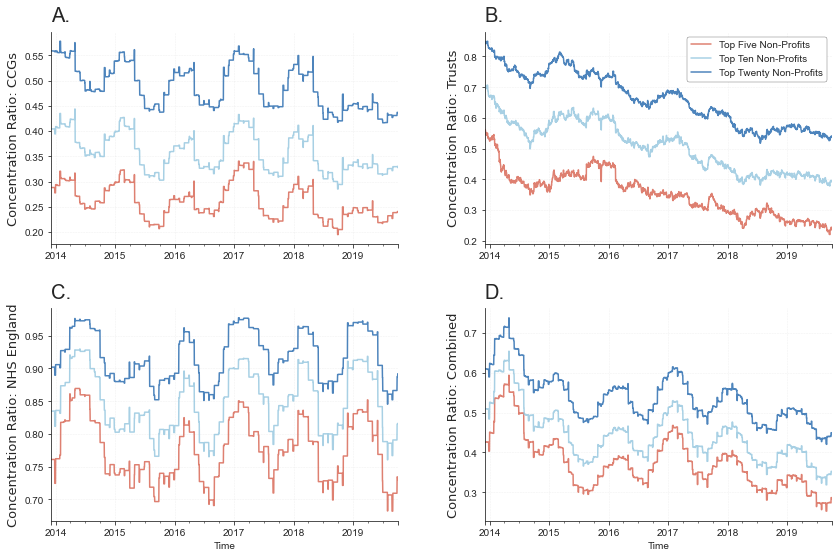

In [66]:
plot_conc(figure_path, rolling_df_45_top10, rolling_df_90_top10,
          rolling_df_180_top10, rolling_df_365_top10)

In [67]:
rolling_df_180_top10.loc['2013-12-01',:]

CCG_Amount_5            0.288182
Trust_Amount_5          0.558934
NHSEngland_Amount_5     0.760871
Combined_Amount_5       0.425666
CCG_Amount_10           0.404363
Trust_Amount_10         0.702672
NHSEngland_Amount_10    0.834807
Combined_Amount_10      0.509095
CCG_Amount_20           0.558848
Trust_Amount_20         0.847503
NHSEngland_Amount_20    0.902049
Combined_Amount_20      0.609683
Name: 2013-12-01 00:00:00, dtype: object

In [69]:
rolling_df_180_top10.loc['2019-10-01', :]

CCG_Amount_5            0.240799
Trust_Amount_5          0.240054
NHSEngland_Amount_5     0.729776
Combined_Amount_5       0.283599
CCG_Amount_10           0.327502
Trust_Amount_10         0.393259
NHSEngland_Amount_10    0.816041
Combined_Amount_10      0.352644
CCG_Amount_20           0.436034
Trust_Amount_20         0.540789
NHSEngland_Amount_20    0.892048
Combined_Amount_20      0.445883
Name: 2019-10-01 00:00:00, dtype: object